In [1]:
import numpy as np
import imageio
from skimage import transform
import matplotlib.pyplot as plt
from math import sqrt
import glob
import subprocess

import extract_features
%matplotlib inline

In [2]:
def load_image(img_path, resize=True):
    tmp_img = imageio.imread(img_path)
    if resize:
        return transform.resize(image=tmp_img,output_shape=(200,200),anti_aliasing=True, mode='constant')
    return tmp_img

In [2]:
%timeit feature = extract_features.get_vector_resnet50('data/images/golden1.jpg')

20 ms ± 290 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [2]:
%timeit feature = extract_features.get_vector_resnet18('data/images/golden1.jpg')

10.4 ms ± 65.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Resnet 50** takes $2$ times the amount of time as **Resnet 18** i.e. $20$ms vs $10$ms.

In [3]:
classes = sorted([path.split("/")[-1] for path in glob.glob("data/videos/*")])
print(classes)

['animals', 'children', 'christmas', 'nature', 'school', 'snow', 'work']


In [2]:
feature = extract_features.get_vector_resnet50('data/images/golden1.jpg')

In [7]:
feature.shape

(2048,)

In [3]:
concat_features = np.repeat([feature], repeats=1000,axis=0)
concat_features.shape

(1000, 2048)

In [6]:
import knn_cnn_features
%time feature_indices = knn_cnn_features.run_knn_features(concat_features,k=3)

Number of records: 1000 
Number of dimensions: 2048
Running with Flat index for 1000 records of with dimensionality 2048
CPU times: user 9.75 ms, sys: 86.7 ms, total: 96.4 ms
Wall time: 94.9 ms


For $1000$ feature vectors of dimensionality $2048$, the KNN search is very fast i.e. around $90$ms. These indices for the feature vectors can be used to get the corresponding videos and thereby similarity search can be implemented.

## Extracting real features (UCF101)

In [2]:
import knn_cnn_features

In [3]:
videos = sorted(glob.glob("data/UCF101/*"))
ucf_classes = [vid.split('/')[-1].split('_')[1] for vid in videos]
ucf_classes = list(set(ucf_classes))
print("There are",len(ucf_classes),"classes in UCF dataset")

There are 101 classes in UCF dataset


In [38]:
# get lengths of all videos
lengths = []
for vid in videos:
    length = !ffprobe -v error -select_streams v:0 -show_entries stream=duration -of \
        default=noprint_wrappers=1:nokey=1 $vid
    length = float(length[0])
    lengths.append(length)

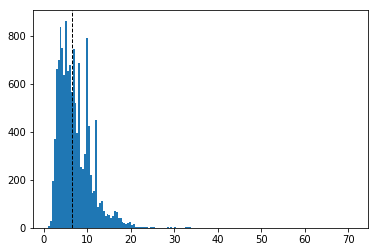

In [45]:
plt.hist(lengths, bins='auto')
plt.axvline(np.median(lengths), color='k', linestyle='dashed', linewidth=1)
plt.show()

In [33]:
num_of_frames = 8 # Using 8 since UCF has a median video length of less than 8 second
def extract_features_from_vid(vid_path):
    p = subprocess.Popen("sh extractNFrames.sh "+vid_path+" "+str(num_of_frames), \
                         stdout=subprocess.PIPE, shell=True)
    p_status = p.wait()
    (output, err) = p.communicate()
    frame_list = glob.glob('data/tmp/*.jpg')
    vid_feature_vector = None
    for fr in frame_list:
        feature_vector = extract_features.get_vector_resnet50(fr)
        if type(vid_feature_vector) is not np.ndarray:
            vid_feature_vector = feature_vector
        else:
            vid_feature_vector = np.vstack((vid_feature_vector, feature_vector))
    return vid_feature_vector

In [40]:
import h5py
h5f = h5py.File('features_UCF_resnet50.h5', 'w')

In [41]:
from tqdm import tqdm
for vid in tqdm(videos):
    test_vfv = extract_features_from_vid(vid)
    h5f.create_dataset(vid,  data=test_vfv)
h5f.close()


  1%|          | 149/13320 [00:34<52:05,  4.21it/s]


  2%|▏         | 297/13320 [01:07<48:19,  4.49it/s]


  3%|▎         | 445/13320 [01:41<47:15,  4.54it/s]


  4%|▍         | 593/13320 [02:14<45:02,  4.71it/s]


  6%|▌         | 741/13320 [02:48<50:30,  4.15it/s]


  7%|▋         | 889/13320 [03:20<41:19,  5.01it/s]


  8%|▊         | 1037/13320 [03:51<42:55,  4.77it/s]


  9%|▉         | 1183/13320 [04:25<52:00,  3.89it/s]


 10%|▉         | 1329/13320 [05:00<45:53,  4.35it/s]


 11%|█         | 1475/13320 [05:35<48:24,  4.08it/s]


 12%|█▏        | 1621/13320 [06:14<51:05,  3.82it/s]


 13%|█▎        | 1766/13320 [06:53<44:50,  4.29it/s]


 14%|█▍        | 1912/13320 [07:27<42:21,  4.49it/s]


 15%|█▌        | 2058/13320 [07:58<39:02,  4.81it/s]


 17%|█▋        | 2204/13320 [08:31<43:15,  4.28it/s]


 18%|█▊        | 2350/13320 [09:07<44:12,  4.14it/s]


 19%|█▊        | 2496/13320 [09:45<41:40,  4.33it/s]


 20%|█▉        | 2642/13320 [10:22<41:47,  4.26it/s]


 21%|██        | 2788/13320 [10:59<43:50,  4.00it/s]


 22%|██▏       | 2934/13320 [11:32<38:12,  4.53it/s]


 23%|██▎       | 3080/13320 [12:06<39:29,  4.32it/s]


 24%|██▍       | 3226/13320 [12:38<38:17,  4.39it/s]


 25%|██▌       | 3372/13320 [13:14<40:03,  4.14it/s]


 26%|██▋       | 3518/13320 [13:50<1:04:08,  2.55it/s]


 28%|██▊       | 3664/13320 [14:30<46:09,  3.49it/s]


 29%|██▊       | 3810/13320 [15:04<35:05,  4.52it/s]


 30%|██▉       | 3956/13320 [15:38<36:56,  4.22it/s]


 31%|███       | 4102/13320 [16:12<33:06,  4.64it/s]


 32%|███▏      | 4248/13320 [16:47<35:29,  4.26it/s]


 33%|███▎      | 4394/13320 [17:22<37:34,  3.96it/s]


 34%|███▍      | 4540/13320 [17:58<37:25,  3.91it/s]


 35%|███▌      | 4686/13320 [18:34<35:22,  4.07it/s]


 36%|███▋      | 4832/13320 [19:10<34:43,  4.07it/s]


 37%|███▋      | 4978/13320 [19:45<31:19,  4.44it/s]


 38%|███▊      | 5124/13320 [20:22<35:12,  3.88it/s]


 40%|███▉      | 5270/13320 [20:58<29:36,  4.53it/s]


 41%|████      | 5416/13320 [21:34<37:57,  3.47it/s]


 42%|████▏     | 5562/13320 [22:12<39:59,  3.23it/s]


 43%|████▎     | 5708/13320 [22:47<25:00,  5.07it/s]


 44%|████▍     | 5854/13320 [23:24<32:52,  3.78it/s]


 45%|████▌     | 6000/13320 [24:02<26:13,  4.65it/s]


 46%|████▌     | 6146/13320 [24:38<32:38,  3.66it/s]


 47%|████▋     | 6292/13320 [25:29<34:27,  3.40it/s]


 48%|████▊     | 6438/13320 [26:04<21:35,  5.31it/s]


 49%|████▉     | 6584/13320 [26:46<36:47,  3.05it/s]


 51%|█████     | 6730/13320 [27:31<26:24,  4.16it/s]


 52%|█████▏    | 6876/13320 [28:07<24:57,  4.30it/s]


 53%|█████▎    | 7022/13320 [28:41<22:18,  4.71it/s]


 54%|█████▍    | 7168/13320 [29:15<25:47,  3.97it/s]


 55%|█████▍    | 7314/13320 [29:52<24:55,  4.02it/s]


 56%|█████▌    | 7460/13320 [30:31<24:21,  4.01it/s]


 57%|█████▋    | 7606/13320 [31:07<20:26,  4.66it/s]


 58%|█████▊    | 7752/13320 [31:41<23:32,  3.94it/s]


 59%|█████▉    | 7898/13320 [32:24<30:59,  2.92it/s]


 60%|██████    | 8044/13320 [33:12<26:57,  3.26it/s]


 61%|██████▏   | 8190/13320 [33:52<22:22,  3.82it/s]


 63%|██████▎   | 8336/13320 [34:36<24:58,  3.33it/s]


 64%|██████▎   | 8482/13320 [35:17<22:18,  3.61it/s]


 65%|██████▍   | 8628/13320 [35:59<25:00,  3.13it/s]


 66%|██████▌   | 8774/13320 [36:42<18:20,  4.13it/s]


 67%|██████▋   | 8920/13320 [37:21<19:52,  3.69it/s]


 68%|██████▊   | 9066/13320 [37:57<17:36,  4.02it/s]


 69%|██████▉   | 9212/13320 [38:34<16:34,  4.13it/s]


 70%|███████   | 9358/13320 [39:14<18:22,  3.59it/s]


 71%|███████▏  | 9504/13320 [39:55<16:43,  3.80it/s]


 72%|███████▏  | 9650/13320 [40:27<13:05,  4.67it/s]


 74%|███████▎  | 9796/13320 [41:05<22:55,  2.56it/s]


 75%|███████▍  | 9942/13320 [41:48<15:06,  3.73it/s]


 76%|███████▌  | 10086/13320 [42:31<12:36,  4.28it/s]


 77%|███████▋  | 10229/13320 [43:09<12:35,  4.09it/s]


 78%|███████▊  | 10372/13320 [43:47<13:50,  3.55it/s]


 79%|███████▉  | 10515/13320 [44:20<12:29,  3.74it/s]


 80%|████████  | 10658/13320 [44:55<10:27,  4.24it/s]


 81%|████████  | 10801/13320 [45:32<14:14,  2.95it/s]


 82%|████████▏ | 10944/13320 [46:11<10:34,  3.74it/s]


 83%|████████▎ | 11087/13320 [46:50<13:30,  2.76it/s]


 84%|████████▍ | 11230/13320 [47:30<09:43,  3.58it/s]


 85%|████████▌ | 11373/13320 [48:05<07:39,  4.24it/s]


 86%|████████▋ | 11516/13320 [48:43<08:57,  3.35it/s]


 88%|████████▊ | 11659/13320 [49:19<07:49,  3.54it/s]


 89%|████████▊ | 11802/13320 [49:55<06:29,  3.90it/s]


 90%|████████▉ | 11945/13320 [50:32<04:57,  4.62it/s]


 91%|█████████ | 12088/13320 [51:10<11:24,  1.80it/s]


 92%|█████████▏| 12231/13320 [51:50<04:15,  4.26it/s]


 93%|█████████▎| 12374/13320 [52:24<03:49,  4.11it/s]


 94%|█████████▍| 12517/13320 [53:01<03:52,  3.45it/s]


 95%|█████████▌| 12660/13320 [53:37<02:45,  3.99it/s]


 96%|█████████▌| 12803/13320 [54:17<02:14,  3.86it/s]


 97%|█████████▋| 12946/13320 [54:56<01:24,  4.45it/s]


 98%|█████████▊| 13089/13320 [55:30<00:54,  4.26it/s]


 99%|█████████▉| 13232/13320 [56:07<00:18,  4.83it/s]


100%|██████████| 13320/13320 [56:26<00:00,  3.70it/s]


## Merging files into single numpy array

In [42]:
hf5 = h5py.File('features_UCF_resnet50.h5', 'r')

In [56]:
feature_vectors = None
for vid in videos:
    if type(feature_vectors) is not np.ndarray:
        feature_vectors = np.array(hf5[vid])
    else:
        feature_vectors = np.vstack((feature_vectors, np.array(hf5[vid])))

In [78]:
merged_h5f = h5py.File('merged_features_UCF_resnet50.h5', 'w')
merged_h5f.create_dataset('feature_vectors', data=feature_vectors)

<HDF5 dataset "feature_vectors": shape (106557, 2048), type "<f4">

In [81]:
feature_labels = []
for vid in videos:
#     if hf5[vid].shape[0]!=8:
    feature_labels.extend([vid]*(hf5[vid].shape[0])) 

In [83]:
merged_h5f.create_dataset('feature_labels', data=np.array(feature_labels, dtype='S'))
mega_h5f.close()

<HDF5 dataset "feature_labels": shape (106557,), type "|S44">

## Testing with real features (UCF101 subset)

In [91]:
feature_file = h5py.File('merged_features_UCF_resnet50.h5', 'r')
feature_labels = np.array([fl.decode() for fl in feature_file['feature_labels']])
%time feature_indices = knn_cnn_features.run_knn_features(np.array(feature_file['feature_vectors']),k=3)

Number of records: 106557 
Number of dimensions: 2048
Running with Flat index for 106557 records of with dimensionality 2048
CPU times: user 13.3 s, sys: 6.01 s, total: 19.3 s
Wall time: 18 s


In [5]:
def vid_from_path(ss = 'data/videos/animals/0.mp4/output0001.jpg'):
    vid_path = ss[:ss.rfind("/")]
#     frame_no = ss[ss.rfind("/")+1:]
    return vid_path

In [92]:
def get_ordered_unique(listed):
    seen = set()
    seen_add = seen.add
    return [x for x in listed if not (x in seen or seen_add(x))]

In [131]:
similar_videos = feature_labels[feature_indices]

In [146]:
def get_cls_accuracy(similar_videos, feature_labels, k=3):
    accuracy = 0
    for i, sim_vids in enumerate(similar_videos):
        true_label = feature_labels[i].split('_')[1]
        for sim_vid in sim_vids:
            pred_label = sim_vid.split('_')[1]
            accuracy += np.sum(pred_label==true_label)/k
    return accuracy/len(feature_labels)

In [150]:
print("Accuracy:",get_cls_accuracy(similar_videos,feature_labels))

Accuracy: 0.964019257295622
